In [4]:
# import GRUs
import os.path as osp
import torch
from backend.models.player_performance_prediction import GruPlayerPredictor as GRU
from backend.models.player_performance_prediction import GroupedGruPlayerPredictor as GRUS

# Model parameters
input_size = 20
gru_hidden_size = 32
linear_output_size = 1
gru_num_layers = 4


features = [
    'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM',
    'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TO',
    'PF', 'PTS', 'PLUS_MINUS'
]

calculated_features = ['FG_PCT', 'FG3_PCT', 'FT_PCT']

grus= {}
models_folder = "backend/models/models32"

for feature in features:
    if feature in calculated_features:
        grus[feature] = None
        continue

    model = GRU(
        input_size,
        gru_hidden_size,
        linear_output_size,
        gru_num_layers=gru_num_layers
    )
    model.load_state_dict(torch.load(osp.join(models_folder,f'{feature}_gru.pt'), map_location="cpu"))
    model.eval()
    grus[feature] = model

grus['FG_PCT'] = lambda x: grus['FGM'](x) / grus['FGA'](x)
grus['FG3_PCT'] = lambda x: grus['FG3M'](x) / grus['FG3A'](x)
grus['FT_PCT'] = lambda x: grus['FTM'](x) / grus['FTA'](x)
gru_model = GRUS(grus)

In [6]:
import joblib
scaler = joblib.load(osp.join(models_folder, 'std_scaler_gru.gz'))

In [7]:
import pandas as pd

df = pd.read_sql_table("game_stats", "sqlite:///backend/database/game_stats.db")
df.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,42024,1610612760,OKC,Oklahoma City Thunder,0042400407,2025-06-22,OKC vs. IND,W,240,103,...,0.710,13,27,40,20,14,8,7,23,12.0
1,42024,1610612754,IND,Indiana Pacers,0042400407,2025-06-22,IND @ OKC,L,240,91,...,0.759,12,33,45,17,6,4,21,24,-12.0
2,42024,1610612760,OKC,Oklahoma City Thunder,0042400406,2025-06-19,OKC @ IND,L,240,91,...,0.808,4,37,41,14,4,4,21,20,-17.0
3,42024,1610612754,IND,Indiana Pacers,0042400406,2025-06-19,IND vs. OKC,W,240,108,...,0.680,11,35,46,23,16,5,10,17,17.0
4,42024,1610612760,OKC,Oklahoma City Thunder,0042400405,2025-06-16,OKC vs. IND,W,239,120,...,0.813,19,26,45,24,15,12,11,24,11.0


In [8]:
df = df[['TEAM_ID', 'GAME_ID', 'WL']]
df = df.replace({'L':0, 'W':1})
df.head()

C:\Users\keira\AppData\Local\Temp\ipykernel_27496\634144404.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'L':0, 'W':1})


,TEAM_ID,GAME_ID,WL
0,1610612760,0042400407,1
1,1610612754,0042400407,0
2,1610612760,0042400406,0
3,1610612754,0042400406,1
4,1610612760,0042400405,1


In [9]:
import json
player_stats_per_game_path = osp.join('backend','json', 'nba_data.json')
with open(player_stats_per_game_path, 'r') as fd:
    player_stats_per_game = json.load(fd)


In [10]:
X = []
y = []
window_size = 3
time_minimum = 10

for i, team, game, wl in df.itertuples():

    team, game = str(team), str(game)

    for player in player_stats_per_game[team]:
        if game in player_stats_per_game[team][player] and len(player_stats_per_game[team][player]) > 3:

            keys = list(player_stats_per_game[team][player].keys())
            start = keys.index(game) + 1
            
            stop = start
            valid_games = 0
            window = []

            # iterate through games until 3 valid (non-empty) games have been added to window
            while stop < len(keys) and valid_games < window_size:
                # Add game if the player played for more than time_minimum minutes
                if len(player_stats_per_game[team][player][keys[stop]]) > 0 and player_stats_per_game[team][player][keys[stop]][0] > time_minimum:
                    window.append(torch.tensor(player_stats_per_game[team][player][keys[stop]]))
                    valid_games += 1

                stop += 1

            # Skip if player didn't have enough games in the window
            if len(window) < 3:
                continue

            window = torch.stack(window)
            window = torch.tensor(scaler.transform(window), dtype=torch.float)
            with torch.no_grad():
                X.append(gru_model.forward(window).squeeze())
            y.append(wl)

    
X = pd.DataFrame(torch.stack(X), columns=features)
y = pd.DataFrame(y, columns=['WL'])

In [ ]:
# Save full data
X['WL'] = y['WL']
X.to_csv('scaled_predicted_player_peformance.csv', index=False)
X = df.drop(['WL'], axis=1)

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
seed = 59
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=seed)

svm = LinearSVC(C=1, random_state=seed)
svm.fit(X_train, y_train['WL'])
print("Train Accuracy:", svm.score(X_train, y_train['WL']))
print("Test Accuracy:", svm.score(X_test, y_test['WL']))
print("Coef:", svm.coef_[0])

Train Accuracy: 0.5618892508143323
Test Accuracy: 0.5510365773141424
Coef: [-2.93998713e-02  6.42012015e-02 -5.37408154e-02 -5.63829905e-05
  6.22263550e-02 -2.49129788e-02  1.40673618e-04 -4.86091119e-02
  5.00856861e-03 -4.77710347e-05 -1.89063835e-02  2.23446874e-02
  1.68049020e-02  4.51488347e-02  2.44825754e-02  7.81375087e-03
 -6.99663318e-02 -3.50630307e-02  5.79557472e-02  3.48281559e-01]


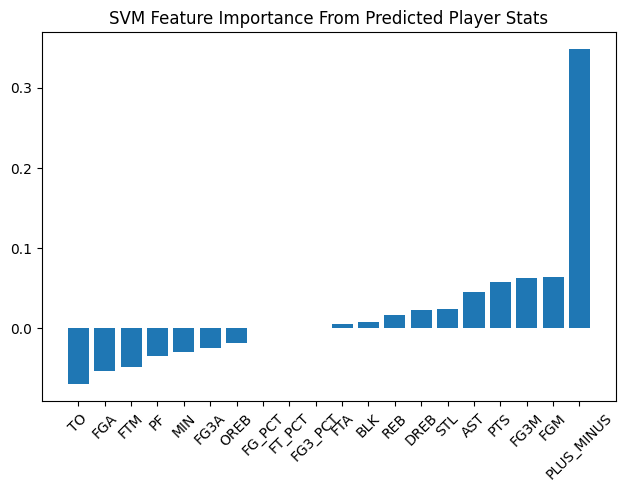

In [81]:
import matplotlib.pyplot as plt
labels_dict = {}
for feature, coef in zip(features, svm.coef_[0]):
    labels_dict[feature] = coef

labels_sorted = dict(sorted(labels_dict.items(), key=lambda item: item[1]))

plt.bar(labels_sorted.keys(), labels_sorted.values())
plt.xticks(rotation=45)
plt.tight_layout()
plt.title("SVM Feature Importance From Predicted Player Stats")
plt.show()